# Mengimpor Dataset dari Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Mengimpor fungsi library

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools
import os

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.util import random_noise

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

import random

# Membuat Dataframe untuk Dataset

In [3]:
mypath= '/content/gdrive/Shareddrives/Soedirman-Machine-Learning/CT SCAN COVID-19/CT/Pre-processed/'

file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [4]:
# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
NiCT    512
nCT     520
pCT     516
dtype: int64

# Membagi Dataset ke dalam Bentuk Train Data dan Test Data

In [5]:
#load library untuk train test split
from sklearn.model_selection import train_test_split

#variabel yang digunakan pada pemisahan data ini
X= df['path']
y= df['tag']

# split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [6]:
# menyatukan kedalam masing-masing dataframe

df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_te = pd.DataFrame({'path':X_test
              ,'tag':y_test
             ,'set':'test'})

In [7]:
print('train size', len(df_tr))
print('test size', len(df_te))

train size 1238
test size 310


In [8]:
# melihat proporsi pada masing masing set apakah sudah ok atau masih ada yang ingin diubah
df_all = df_tr.append([df_te]).reset_index(drop=1)\

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

#cek sample datanya
df_all.sample(3)


set    tag 
test   NiCT    104
       nCT     106
       pCT     100
train  NiCT    408
       nCT     414
       pCT     416
dtype: int64 




,path,tag,set
1189,/content/gdrive/Shareddrives/Soedirman-Machine...,NiCT,train
828,/content/gdrive/Shareddrives/Soedirman-Machine...,NiCT,train
365,/content/gdrive/Shareddrives/Soedirman-Machine...,pCT,train


In [9]:
import shutil
from tqdm.notebook import tqdm as tq
import shutil
import os, sys

# Membuat Folder Baru untuk Dataset

In [10]:
## create folders
os.makedirs('Dataset3/')

# Menyalin Dataset ke dalam Folder Dataset Baru

In [11]:
datasource_path = "/content/gdrive/Shareddrives/Soedirman-Machine-Learning/CT SCAN COVID-19/CT/Pre-processed/"
dataset_path = "Dataset3/"

for index, row in tq(df_all.iterrows()):
    
    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# Pre-processing dan Augmentasi Data

In [12]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split = 0.2,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.1,    
    vertical_flip = True,
    fill_mode = "nearest")

# Mengimpor Dataset

In [13]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 66
base_dir = os.path.join('Dataset3/train/')



train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training',
    class_mode= 'categorical')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation',
    class_mode= 'categorical')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['NiCT',
          'nCT',
          'pCT']

for i,label in enumerate(labels):
    folder = os.path.join("Dataset3/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 992 images belonging to 3 classes.
Found 246 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (66, 224, 224, 3) (66, 3)
Bentuk array dari dataset validation (validasi) adalah: (66, 224, 224, 3) (66, 3)
Bentuk array dari dataset test (pengujian) adalah: (310, 224, 224) (310,)


# Menyimpan label

In [14]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'NiCT': 0, 'nCT': 1, 'pCT': 2}


In [15]:
!cat labels.txt

NiCT
nCT
pCT

# Membuat model CNN

In [16]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

base_model.trainable = False
base_model.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [17]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

In [18]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(2048, 3, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(1024, 3, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(512, 3, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
]
)

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 2048)        37750784  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 2048)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 1024)        18875392  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 1024)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 512)         4719104   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 512)         0

# Melatih Model

In [19]:
history = model.fit_generator(train_generator, 
                    epochs=50, 
                    validation_data=val_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
16/16 [==============================] - 65s 2s/step - loss: 21.3882 - acc: 0.3276 - val_loss: 1.1251 - val_acc: 0.3333
Epoch 2/50
16/16 [==============================] - 21s 1s/step - loss: 1.1166 - acc: 0.3296 - val_loss: 1.1015 - val_acc: 0.3333
Epoch 3/50
16/16 [==============================] - 21s 1s/step - loss: 1.1091 - acc: 0.3558 - val_loss: 1.0676 - val_acc: 0.6911
Epoch 4/50
16/16 [==============================] - 21s 1s/step - loss: 1.0985 - acc: 0.3679 - val_loss: 1.0081 - val_acc: 0.6626
Epoch 5/50
16/16 [==============================] - 21s 1s/step - loss: 0.9834 - acc: 0.4788 - val_loss: 0.9550 - val_acc: 0.4878
Epoch 6/50
16/16 [==============================] - 21s 1s/step - loss: 0.8064 - acc: 0.5806 - val_loss: 0.6437 - val_acc: 0.6382
Epoch 7/50
16/16 [==============================] - 20s 1s/step - loss: 0.7279 - acc: 0.6129 - val_loss: 1.2405 - val_acc: 0.3333
Epoch 8/50
16/16 [==============================] - 21s 1s/step - loss: 1.1987 - acc: 0.3

# Menampilkan Hasil Pelatihan

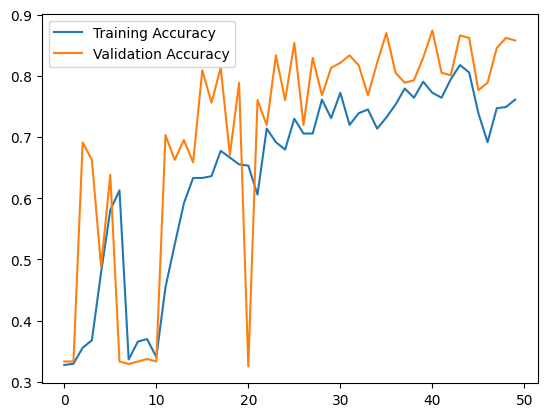

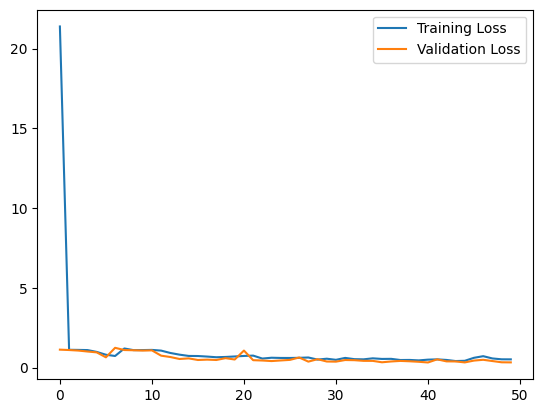

In [20]:
plt.plot(history.history["acc"],label="Training Accuracy")
plt.plot(history.history["val_acc"],label="Validation Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend()
plt.show()

# Memuat Dataset Pengujian

In [21]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

# Mengevaluasi Model

In [22]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

X_test = np.repeat(np.expand_dims(X_test, axis=3), 3, axis=3)
#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 1 1 1 1 1 1 2
 1 1 2 1 2 1 1 1 2 1 2 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1
 2 2 2 1 1 1 2 2 2 1 1 1 1 1 2 1 2 1 1 1 1 2 1 1 2 2 1 1 2 1 1 2 1 1 1

# Menggunakan Model

In [23]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 8


# Memprediksi Citra Secara Individu

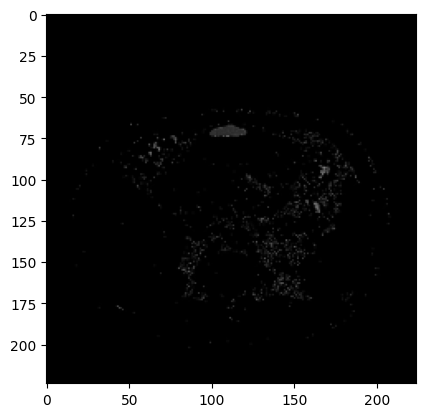

Label yang benar adalah: 0 : NiCT
Nilai yang diprediksi adalah: [0.99676055 0.00220998 0.00102945]
Label yang diprediksi adalah: 0 : NiCT
Prediksi benar


In [24]:
n = 44 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

# Confusion Matrix

Normalized confusion matrix
[[0.91 0.05 0.04]
 [0.   0.68 0.32]
 [0.   0.26 0.74]]


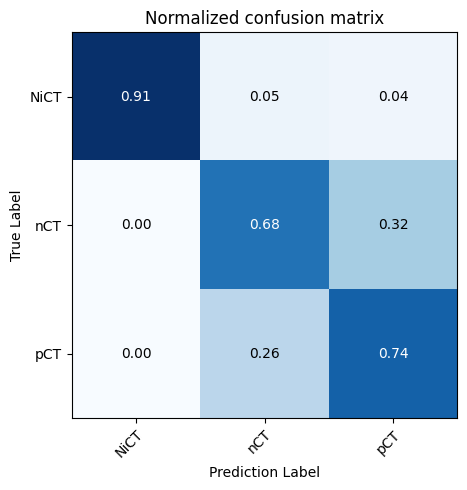

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True Label',
           xlabel='Prediction Label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [26]:
from sklearn import metrics
import itertools

def get_confusion_matrix(y_true, Y_pred):
    n_classes = len(np.unique(y_true))
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(y_true, y_pred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

conf = get_confusion_matrix(y_test, y_pred)
conf

array([[95,  5,  4],
       [ 0, 72, 34],
       [ 0, 26, 74]])

Text(0.5, 23.52222222222222, 'Prediction Label')

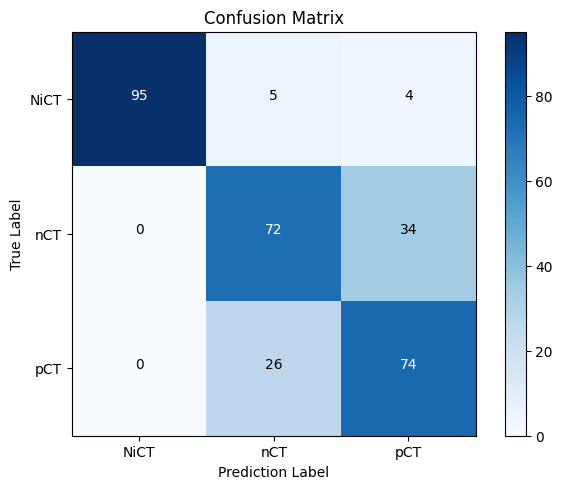

In [27]:
classes = labels
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Prediction Label')

In [28]:
from sklearn.metrics import classification_report
print (classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       104
           1       0.70      0.68      0.69       106
           2       0.66      0.74      0.70       100

    accuracy                           0.78       310
   macro avg       0.79      0.78      0.78       310
weighted avg       0.79      0.78      0.78       310



In [29]:
from sklearn.metrics import auc
print (auc(y_true, y_pred))

3.0


# Menyimpan dan mengkonversi Model ke ".tflite"

In [30]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('CTScans_for_Covid19_Classification_MobileNet.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/model/assets
